In [43]:
%%capture
%pip install opencv-python
%pip install tqdm
%pip install tensorflow
%pip install imageio
%pip install tensorflow_docs
%pip install scikit-learn
%pip install matplotlib

In [44]:
import random
import pathlib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import itertools
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
from tensorflow.keras.metrics import Precision, Recall

In [45]:
subset_paths = {}
subset_paths['train'] = Path('../Data/train')
subset_paths['test'] = Path('../Data/test')
subset_paths['val'] = Path('../Data/val')

In [46]:
def format_frames(frame, output_size):
    """
      Pad and resize an image from a video.

      Args:
        frame: Image that needs to resized and padded.
        output_size: Pixel size of the output frame image.

      Return:
        Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [47]:

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
      Creates frames from each video file present for each category.

      Args:
        video_path: File path to the video.
        n_frames: Number of frames to be created per video file.
        output_size: Pixel size of the output frame image.

      Return:
        An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

In [48]:

class FrameGenerator:
    def __init__(self, path, n_frames, training=False):
        """ Returns a set of frames with their associated label.

          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(
            set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx)
                                       for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]  # Encode labels
            yield video_frames, label


In [49]:
output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

In [50]:
num_frames = 6

train_ds = tf.data.Dataset.from_generator(FrameGenerator(
    subset_paths['train'], num_frames, training=True),                                        output_signature=output_signature)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], num_frames),
                                        output_signature=output_signature)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature=output_signature)

In [51]:
train_frames, train_labels = next(iter(train_ds))
val_frames, val_labels = next(iter(val_ds))

In [52]:
# example of tensor frame
train_frames[num_frames-1][100][100][2].numpy()

0.45310646

In [53]:
# the _frames is a 4D array to descibe the pixels in a "video" (not actually a video but rather a gorup of frames to represent a video) 
# val_frames[# of frame in the video burst][height of pixel][width of pixel][R:G:B value]
# ex. val_frames[2][0][0][2] will give the Blue value for the second frame in a video in the top left corner (since height = width = 0) and we will see the blue value (3rd in RGB)
print(f'shape of val_frames is ({num_frames}=number of frames 224=height in pixels 224=width in pixels 3=RBG value of the pixel )')

print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

shape of val_frames is (6=number of frames 224=height in pixels 224=width in pixels 3=RBG value of the pixel )
Shape of validation set of frames: (6, 224, 224, 3)
Shape of validation labels: ()


In [54]:
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

Shape of training set of frames: (6, 224, 224, 3)
Shape of training labels: ()


In [55]:
fg = FrameGenerator(
    subset_paths['train'], 6, training=True)
output_signature


(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int16, name=None))

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


In [57]:
batch_size = 3
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [58]:
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

In [75]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D(),
    # this should make this classification binary but it isn't working
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [76]:
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 6),                                       output_signature=output_signature)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(2)
test_frames, test_labels = next(iter(test_ds))

In [77]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define a list of loss functions to try
loss_functions = ['binary_crossentropy']

# Dictionary to store results for each loss function
results = {}

for loss_function in loss_functions:
    # Compile the model with the current loss function
    model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

    # Train the model
    model.fit(train_ds, epochs=1,  validation_data=(val_ds))

    # Evaluate the model on the validation set
    y_pred = model.predict(test_ds,  verbose=1)

    # Convert probabilities to classes (adjust threshold if needed)
    # y_pred_classes = (y_pred > 0.5).astype(int)
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_true_list = []
    for data, labels in test_ds:
        y_true_list.extend(labels.numpy())

    y_true = np.array(y_true_list)
    y_pred_bool = np.array(y_pred_bool)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_bool)
    precision = precision_score(y_true, y_pred_bool, average='weighted')
    recall = recall_score(y_true, y_pred_bool, average='weighted')

    # Store results in the dictionary
    results[loss_function] = {'accuracy': accuracy, 'precision': precision, 'recall': recall}

# Print the results
for loss_function, metrics in results.items():
    print(f"Loss Function: {loss_function}, Metrics: {metrics}")


43/43 [==============================] - 40s 619ms/step
Loss Function: binary_crossentropy, Metrics: {'accuracy': 0.7325581395348837, 'precision': 0.5366414277988102, 'recall': 0.7325581395348837}


C:\Users\tassc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


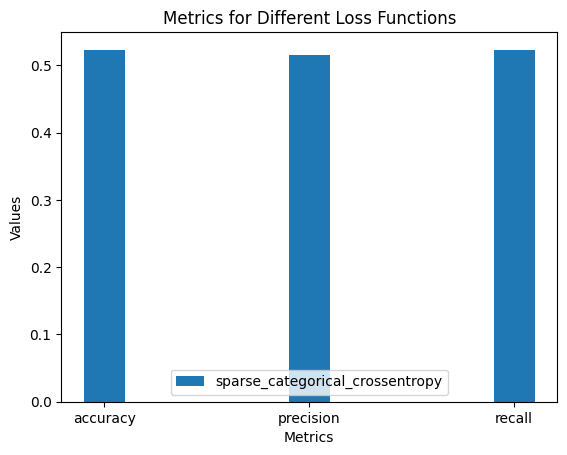

In [69]:

# Extract metrics and labels from the dictionary
loss_functions = list(results.keys())
metric_labels = list(results['sparse_categorical_crossentropy'].keys())
values = np.array([list(metrics.values()) for metrics in results.values()])

# Plotting dynamically
bar_width = 0.2  # Width of each bar
num_metrics = len(metric_labels)
index = np.arange(num_metrics)

# Plotting
for i, loss_function in enumerate(loss_functions):
    plt.bar(index + i * bar_width, values[i], bar_width, label=loss_function)

# Customize the plot
plt.title('Metrics for Different Loss Functions')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(index + (len(loss_functions) - 1) * bar_width / 2, metric_labels)
plt.legend()
plt.show()